Import the required packages and libraries.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

Read the metadata JSON file in order to build a dictionary and assign to each article a unique identifier (different from the DOI for easiest management of the network).

- metadata_dict -> contains all the articles and their data
- nodes -> dictionary containing tuples to map from DOI to node_id and journal title
- journals_dict -> dictionary to map from Journal_title to unique_id of the journal 

In [15]:
# Read metadata JSON file in order to build a dictionary
metadata = open("metadata.json")
metadata_dict = json.load(metadata)

# Create a dict of pairs "doi: (node_id, journal_title)"
nodes = dict()
reverse_nodes = dict()

# Create a dict of pairs "Journal: unique_identifier"
journals_dict = {}

# Add a number as unique identifier of each one of the papers and to each Journal
i = 0
j = 0
for paper in metadata_dict:
    new_journal = False
    paper["node_id"] = i
    nodes[paper['id']] = (paper['node_id'], paper['source_title'])
    if paper['source_title'] not in journals_dict:
        journals_dict[paper['source_title']] = j
        reverse_nodes[paper['node_id']] = (paper['id'], paper['source_title'], j)
        new_journal = True
    else:
        idx = journals_dict[paper['source_title']]
        reverse_nodes[paper['node_id']] = (paper['id'], paper['source_title'], idx)
    i+=1
    # art_id : (doi, journ_title, journ_id)
    if new_journal:
        j+=1

First network: articles

In [3]:
papers_network = nx.DiGraph()

In [4]:
# Read citations JSON file in order to build a dictionary
citations = open('citations.json')
citations_dict = json.load(citations)

In [5]:
# Iterate over citations_dict to build a journals citations' network
for citation_obj in tqdm(citations_dict):
    source = citation_obj['source']
    target = citation_obj['target']
    if source in nodes:
        if target in nodes:
            source_article_id = nodes[source][0]
            target_article_id = nodes[target][0]
            papers_network.add_edge(source_article_id, target_article_id)

100%|██████████| 189697/189697 [00:00<00:00, 387179.30it/s]


In [9]:
pr = nx.pagerank(papers_network, alpha=0.85)
pr_list = sorted(pr.items(), key=lambda item: item[1], reverse=True)
pr_list

[(39264, 0.003958045367325669),
 (17440, 0.0034456482660907505),
 (21306, 0.0031866534313306017),
 (25837, 0.002695082402101789),
 (12204, 0.002360879446452903),
 (26129, 0.002305909452775167),
 (12343, 0.002106388438053257),
 (7812, 0.0020691617187695984),
 (40899, 0.002012513218906165),
 (8523, 0.001937907687581662),
 (7573, 0.0018446429959122319),
 (13497, 0.0017858247145916646),
 (26347, 0.0013872477547294958),
 (4212, 0.0013400330698184852),
 (14321, 0.0013368983145352557),
 (40607, 0.0012087719493754636),
 (2883, 0.0011787700327177831),
 (1309, 0.0011633113415966461),
 (35740, 0.0010887784139091451),
 (8690, 0.001038583108748586),
 (25492, 0.001033796150810318),
 (19253, 0.000978599763147506),
 (2750, 0.0009722408998811178),
 (37156, 0.0009716697702568396),
 (2608, 0.000909994171845777),
 (7631, 0.0009043413795882051),
 (24293, 0.0008885521021966464),
 (46699, 0.0008813576389040784),
 (24651, 0.0008655335134827691),
 (20861, 0.0008453928658172722),
 (18807, 0.0008194679992225698)

In order:
- Read the JSON file containing citations' pairs;
- Create a dictionary called "journal_citations" to store the different citations from journal to journal. The structure of this dictonary will be: "citing_journal_id: list_of_cited_journal_ids" (obviously, in the list we have repetitions of cited journals if articles cites more than one paper of the target journal);
- Populate the network as said above. This is accomplished thanks to a temporary "memo" dict that stores each citations to every target journal and that is initialized every time the source journal changes.
- Populate the "weights" dictionary. Such dictionary will contain the weight of each specific path retrieved and will be used to assign edge attributes to the network.
- article_citations contains pairs of "source article:[list of cited articles]".

To retrieve the importance of edges in between journals:
- $\tau_j$ = eigenvector value
- $\Gamma_J$ = importance of a journal
- $j$ = article
- $n_j$ = # articles in journal J
- $n_{c_{AB}}$ = # of citations from journal A to journal B
$$\Gamma_J = \dfrac{\sum \tau}{n_j}$$
</br>

$$\omega_{AB} = \dfrac{1}{\Gamma_J*n_{c_{AB}}}$$

Compute the importance of each journal.

In [31]:
journal_weights = dict()

for paper in pr_list:
    publication_id = paper[0]
    node_centrality = paper[1]
    if publication_id in reverse_nodes:
        if reverse_nodes[publication_id][2] not in journal_weights:
            journal_weights[reverse_nodes[publication_id][2]] = [0,0]
        journal_weights[reverse_nodes[publication_id][2]][0] += node_centrality
        journal_weights[reverse_nodes[publication_id][2]][1] += 1
journal_weights

{112: [0.021886379535500402, 265],
 82: [0.01881544363325037, 256],
 44: [0.017634751237738812, 519],
 265: [0.008970468019103627, 142],
 457: [0.0030780857974981373, 45],
 129: [0.017180549427590314, 598],
 79: [0.010868142418307114, 431],
 95: [0.013104958239541241, 587],
 53: [0.026740393455833362, 1059],
 74: [0.01690066574722916, 831],
 382: [0.0011586694976856845, 8],
 179: [0.009473186934402966, 313],
 24: [0.08199669061594116, 2848],
 317: [0.004038865896572892, 112],
 131: [0.006665316792672222, 244],
 29: [0.009521107951207705, 251],
 510: [0.0022677202841824284, 34],
 375: [0.00857483268391216, 292],
 157: [0.003485817351775305, 93],
 184: [0.0065688205303837816, 360],
 115: [0.005499134950266677, 213],
 137: [0.0018679425089448125, 43],
 452: [0.004494617373679316, 131],
 58: [0.0020459004621115155, 91],
 804: [0.001435695113895547, 39],
 83: [0.006009503664983162, 210],
 30: [0.01627340672191337, 535],
 76: [0.004156930416115007, 97],
 135: [0.006938238245243403, 244],
 13

Compute relative importance of journals

In [32]:
for journal in journal_weights:
    journal_weights[journal] = journal_weights[journal][0] / journal_weights[journal][1]
journal_weights

{112: 8.25901114547185e-05,
 82: 7.349782669238426e-05,
 44: 3.397832608427517e-05,
 265: 6.317230999368751e-05,
 457: 6.840190661106972e-05,
 129: 2.8730015765201195e-05,
 79: 2.521610769908843e-05,
 95: 2.2325312162761908e-05,
 53: 2.5250607607019227e-05,
 74: 2.03377445815032e-05,
 382: 0.00014483368721071057,
 179: 3.0265772953364108e-05,
 24: 2.8790972828631024e-05,
 317: 3.6061302647972255e-05,
 131: 2.7316872101115665e-05,
 29: 3.793270100082751e-05,
 510: 6.669765541713025e-05,
 375: 2.9365865355863563e-05,
 157: 3.748190700833661e-05,
 184: 1.8246723695510505e-05,
 115: 2.5817534977777827e-05,
 137: 4.344052346383285e-05,
 452: 3.431005628762837e-05,
 58: 2.2482422660566105e-05,
 804: 3.681269522809095e-05,
 83: 2.8616684118967437e-05,
 30: 3.0417582657782e-05,
 76: 4.285495274345368e-05,
 135: 2.8435402644440177e-05,
 132: 2.063409937516352e-05,
 180: 2.1473963841775787e-05,
 28: 2.3893551703825345e-05,
 138: 1.9292530266327353e-05,
 506: 2.3807009255511082e-05,
 479: 2.49582

Compute citations between journals

In [34]:
journal_citations = dict()
article_citations = dict()

# Iterate over citations_dict to build a journals citations' network
for citation_obj in tqdm(citations_dict):
    source = citation_obj['source']
    target = citation_obj['target']
    if source in nodes:
        if target in nodes:
            source_article = nodes[source][0]
            target_article = nodes[target][0]
            if source_article != target_article:
                if source_article not in article_citations:
                    article_citations[source_article] = list()
                article_citations[source_article].append(target_article)
                source_journal = nodes[source][1]
                target_journal = nodes[target][1]
                if source_journal in journals_dict:
                    if target_journal in journals_dict:
                        jorunal_source_id = journals_dict[source_journal]
                        journal_target_id = journals_dict[target_journal]
                        if jorunal_source_id not in journal_citations:
                            journal_citations[jorunal_source_id] = list()
                        journal_citations[jorunal_source_id].append(journal_target_id)

100%|██████████| 189697/189697 [00:00<00:00, 533847.88it/s]


Build the second network:
- journals_network -> such network will have the different journals as nodes; the edges will be weighted with the reciprocal of the number of citations of articles that goes from journal A to journal B. To be more accurate, it is correct to specify that target nodes without citations won't be considered at all, giving thus the possibility to avoid the definition of a normalization constant (that could have been useful to avoid 0-weigths in paths).

In [37]:
# Build the citations graph
journals_network = nx.DiGraph()

In [38]:
# Add nodes to the graph
weights = dict()

for source_id in journal_citations:
    memo = dict()
    for target_id in journal_citations[source_id]:
        if target_id not in memo:
            memo[target_id] = 0
        memo[target_id] += 1
    for cited_journal in memo:
        weights[(source_id, cited_journal)] = 1/(journal_weights[source_id]*memo[cited_journal])
        journals_network.add_edge(source_id, cited_journal)

Assign edge_attributes to the network, according to the previously computed weights.

In [40]:
nx.set_edge_attributes(journals_network, weights, "relative_weights")

Compute the "betweenness_centrality" measure to retrieve the most important journals. The parameter "weight" will contain the weights attributed to the network in the previous snippet.</br>
The "normalized=True" attribute is useful, in this case, because provides a normalization measure for the direct network.

In [41]:
journals_weighted_betweennes = nx.betweenness_centrality(journals_network, k=None, normalized=True, weight='relative_weights', endpoints=False, seed=None)

Print the 100 most influential journals.

In [42]:
journals_influence = sorted(journals_weighted_betweennes.items(), key=lambda item: item[1], reverse=True)
journals_influence[:100]

[(24, 0.07327742146605086),
 (156, 0.030148203256410412),
 (53, 0.025925579204212013),
 (112, 0.022402601294846176),
 (9, 0.022215536673136835),
 (41, 0.021730446271925843),
 (95, 0.019339108002971624),
 (30, 0.018443343752699688),
 (66, 0.01778873467532449),
 (44, 0.01656592053692261),
 (132, 0.015709753316275277),
 (129, 0.014285052255646054),
 (74, 0.011186973323754498),
 (319, 0.010319850798066623),
 (265, 0.0100537580604477),
 (29, 0.01003877498872614),
 (131, 0.009708430575271225),
 (452, 0.009177661360613956),
 (79, 0.008070529220760693),
 (539, 0.007545466068934214),
 (100, 0.007304778715158644),
 (1768, 0.00628422684524688),
 (80, 0.005964560229150045),
 (457, 0.005740211883934308),
 (179, 0.005334095501829079),
 (379, 0.005069229772520852),
 (3610, 0.004942261393976307),
 (138, 0.004839616817892889),
 (165, 0.004187802662424581),
 (40, 0.004054447019408499),
 (137, 0.003572972566335439),
 (464, 0.0030697244628494166),
 (414, 0.00292197017325829),
 (27, 0.002841781270721087),


In [43]:
papers_network

Extract the title of the most influential journal.

In [48]:
for journal_title in journals_dict:
    if journals_dict[journal_title] == journals_influence[0][0]:
        most_influential_journal = journal_title
        break
most_influential_journal

'Journal Of Virology'

Count the number of outgoing edges from each article in the dataset.

In [49]:
# Raw count of how many articles each specific article cites
article_citations_tot = dict()

for citation in citations_dict:
    if citation['source'] in nodes:
        source_article_id = nodes[citation['source']][0]
        if citation['target'] in nodes:
            target_article_id = nodes[citation['target']][0]
            if source_article_id != target_article_id:
                if source_article_id not in article_citations_tot:
                    article_citations_tot[source_article_id] = 0
                article_citations_tot[source_article_id] += 1

Build a "journals_sizes" dictionary, containing pairs "journal_id: journal_size", retrieved by the betweenness centrality dictionary computed above.

In [50]:
journal_influences = journals_weighted_betweennes

In the following snippet, is given a weight to citations between articles.</br>
Such weight is computed in the following way:
- $n$ is the raw count of out-going citations from a certain article;
- $\alpha$ is the influence of the specific journal containing the citing article (computed with the betweenness centrality measure);
- $\lambda$ is a constant ($\lambda = 0.1$) that is useful to normalize weights equal to $0$;
</br>
Following a flow of information that goes from the source article to the cited one, the relative weight ($\Phi_{ij}$) of the connection between "article $A$" and "article $B$" is computed as follows:</br>

$$\Phi_{AB} = \dfrac{\alpha + \lambda}{n}$$ 
</br>

The idea behind this computation derives from the will to distribute the importance of a certain article between all the articles that it cites in an equal way. Furthermore, higher the number of cited articles -> smaller the importance passed to each one of them.


In [51]:
paper_weights = dict()

for paper in pr_list:
    paper_id = paper[0]
    paper_weight = paper[1]
    paper_weights[paper_id] = paper_weight
paper_weights

{39264: 0.003958045367325669,
 17440: 0.0034456482660907505,
 21306: 0.0031866534313306017,
 25837: 0.002695082402101789,
 12204: 0.002360879446452903,
 26129: 0.002305909452775167,
 12343: 0.002106388438053257,
 7812: 0.0020691617187695984,
 40899: 0.002012513218906165,
 8523: 0.001937907687581662,
 7573: 0.0018446429959122319,
 13497: 0.0017858247145916646,
 26347: 0.0013872477547294958,
 4212: 0.0013400330698184852,
 14321: 0.0013368983145352557,
 40607: 0.0012087719493754636,
 2883: 0.0011787700327177831,
 1309: 0.0011633113415966461,
 35740: 0.0010887784139091451,
 8690: 0.001038583108748586,
 25492: 0.001033796150810318,
 19253: 0.000978599763147506,
 2750: 0.0009722408998811178,
 37156: 0.0009716697702568396,
 2608: 0.000909994171845777,
 7631: 0.0009043413795882051,
 24293: 0.0008885521021966464,
 46699: 0.0008813576389040784,
 24651: 0.0008655335134827691,
 20861: 0.0008453928658172722,
 18807: 0.0008194679992225698,
 38456: 0.0007844074881012957,
 40742: 0.0007810223409704752

Build a new network, that is the citation network of publications contained within the most influential journal.

In [54]:
publications_network = nx.DiGraph()

In [56]:
# articles_weights contains pairs of "(tuple source-target): weight of the connection"
articles_weights = dict()

for citation in tqdm(citations_dict):
    found_all = False
    if citation['source'] in nodes:
        source_article_id = nodes[citation['source']][0]
        source_journal = nodes[citation['source']][1]
        if source_journal in journals_dict:
            source_journal_id = journals_dict[source_journal]
            if source_journal_id in journal_influences:
                if source_article_id in article_citations_tot:
                    article_distributed_weight = ((journal_influences[source_journal_id]/article_citations_tot[source_article_id])*paper_weights[source_article_id])
                    found_all = True
    if found_all:
        if source_article_id in article_citations:
            for cited_article_id in article_citations[source_article_id]:
                if source_article_id != cited_article_id:
                    publications_network.add_edge(source, target)
                    articles_weights[(source_article_id, cited_article_id)] = article_distributed_weight

100%|██████████| 189697/189697 [00:06<00:00, 28126.04it/s]


Set the weights of edges within the most influential journal citations network.

In [58]:
nx.set_edge_attributes(publications_network, articles_weights, "relative_new_nodes_weights")

Finally, we compute the eigenvector centrality in order to find which publications can be identified as key publications within the most influential journal.

In [59]:
key_papers = nx.eigenvector_centrality(publications_network, max_iter=1000, weight='relative_new_nodes_weights')

In [60]:
three_key_papers = sorted(key_papers.items(), key=lambda item: item[1], reverse=True)[:3]
three_key_papers

[(14588, 0.9993803426842699),
 (20916, 0.0010053218011925919),
 (14255, 0.0010041690150229346)]

In [61]:
for paper in metadata_dict:
    if paper['node_id'] == three_key_papers[0][0]:
        key_paper_1 = paper
    if paper['node_id'] == three_key_papers[1][0]:
        key_paper_2 = paper
    if paper['node_id'] == three_key_papers[2][0]:
        key_paper_3 = paper

In [62]:
key_paper_1

{'id': '10.1128/jvi.79.21.13399-13411.2005',
 'author': 'Graham, Sims, Brockway, Baric, Denison',
 'year': '2005',
 'title': 'The Nsp2 Replicase Proteins Of Murine Hepatitis Virus And Severe Acute Respiratory Syndrome Coronavirus Are Dispensable For Viral Replication',
 'source_title': 'Journal Of Virology',
 'node_id': 14588}

In [63]:
key_paper_2

{'id': '10.1128/jvi.01199-08',
 'author': 'Roth-Cross, Bender, Weiss',
 'year': '2008',
 'title': 'Murine Coronavirus Mouse Hepatitis Virus Is Recognized By Mda5 And Induces Type I Interferon In Brain Macrophages/Microglia',
 'source_title': 'Journal Of Virology',
 'node_id': 20916}

In [64]:
key_paper_3

{'id': '10.1128/jvi.01012-07',
 'author': 'Frieman, Yount, Heise, Kopecky-Bromberg, Palese, Baric',
 'year': '2007',
 'title': 'Severe Acute Respiratory Syndrome Coronavirus Orf6 Antagonizes Stat1 Function By Sequestering Nuclear Import Factors On The Rough Endoplasmic Reticulum/Golgi Membrane',
 'source_title': 'Journal Of Virology',
 'node_id': 14255}

------
Below is provided a function to retrieve all the publications within each specific journal. Such function won't be used but may be useful for others who want to analyze more than a single journal.

In [12]:
# journals_articles contains pairs of "journal_id: list(article_ids of articles in that journal)"
journals_articles = dict()

for doi in nodes:
    journal_title = nodes[doi][1]
    if journal_title in journals_dict:
        journal_id = journals_dict[journal_title]
        if journal_id not in journals_articles:
            journals_articles[journal_id] = list()
        journals_articles[journal_id].append(nodes[doi][0])

-------

Retrieve all the publications within the most influential journal and populate the previously created citation network with them.

In [55]:
weighted_citations_in_journal = dict()

for citation in tqdm(citations_dict):
    if citation['source'] in nodes:
        if nodes[citation['source']][1] == most_influential_journal:
            source = nodes[citation['source']][0]
            if citation['target'] in nodes:
                if nodes[citation['target']][1] == most_influential_journal:
                    target = nodes[citation['target']][0]
                    if source != target:
                        weighted_citations_in_journal[(source, target)] = articles_weights[(source, target)]
                        publications_network.add_edge(source, target)

100%|██████████| 189697/189697 [00:00<00:00, 1262190.28it/s]


Retrieve the 3 most important papers within the most influential journal.

In [18]:
for paper in metadata_dict:
    if paper['node_id'] == three_key_papers[0][0]:
        key_paper_1 = paper
    if paper['node_id'] == three_key_papers[1][0]:
        key_paper_2 = paper
    if paper['node_id'] == three_key_papers[2][0]:
        key_paper_3 = paper

Print the results.

In [19]:
key_paper_1

{'id': '10.1128/jvi.01245-08',
 'author': 'KräHling, Stein, Spiegel, Weber, MüHlberger',
 'year': '2008',
 'title': 'Severe Acute Respiratory Syndrome Coronavirus Triggers Apoptosis Via Protein Kinase R But Is Resistant To Its Antiviral Activity',
 'source_title': 'Journal Of Virology',
 'node_id': 6389}

In [20]:
key_paper_2

{'id': '10.1128/jvi.02744-05',
 'author': 'Li, Berardi, Li, Farzan, Dormitzer, Harrison',
 'year': '2006',
 'title': 'Conformational States Of The Severe Acute Respiratory Syndrome Coronavirus Spike Protein Ectodomain',
 'source_title': 'Journal Of Virology',
 'node_id': 29134}

In [21]:
key_paper_3

{'id': '10.1128/jvi.00442-08',
 'author': 'Li',
 'year': '2008',
 'title': 'Structural Analysis Of Major Species Barriers Between Humans And Palm Civets For Severe Acute Respiratory Syndrome Coronavirus Infections',
 'source_title': 'Journal Of Virology',
 'node_id': 10199}

In [22]:
nx.write_gml(publications_network, "pub_network.gml")
nx.write_gml(journals_network, "journals_network.gml")

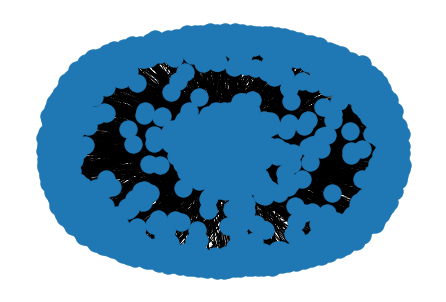

In [23]:
nx.draw(publications_network)